In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [ ]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO(conv_num=1):
    channel_size = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', 
                  activation='relu')) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))         
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         3104      
_________________________________________________________________
flatten (Flatten)            (None, 512000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 512000)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                8192016   
Total params: 8,195,248
Trainable params: 8,195,248
Non-trainable params: 0
___________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5333, 32)          3104      
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 5333, 32)          3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 5333, 32)          3104      
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5333, 32)          3104      
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3574 - acc: 0.2385
Epoch 00001: val_loss improved from inf to 1.83400, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_4_conv_checkpoint/001-1.8340.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 2.3574 - acc: 0.2385 - val_loss: 1.8340 - val_acc: 0.4146
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7078 - acc: 0.4564
Epoch 00002: val_loss improved from 1.83400 to 1.56936, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_4_conv_checkpoint/002-1.5694.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.7077 - acc: 0.4564 - val_loss: 1.5694 - val_acc: 0.4857
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4956 - acc: 0.5249
Epoch 00003: val_loss improved from

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2507 - acc: 0.9181
Epoch 00026: val_loss did not improve from 1.13993
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2507 - acc: 0.9181 - val_loss: 1.5433 - val_acc: 0.6681
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2399 - acc: 0.9221
Epoch 00027: val_loss did not improve from 1.13993
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2399 - acc: 0.9222 - val_loss: 1.5672 - val_acc: 0.6611
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2243 - acc: 0.9270
Epoch 00028: val_loss did not improve from 1.13993
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2243 - acc: 0.9269 - val_loss: 1.6228 - val_acc: 0.6653
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2101 - acc: 0.9307
Epoch 00029: val_loss did not improve from 1.13993
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0947 - acc: 0.9701
Epoch 00056: val_loss did not improve from 1.13993
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0947 - acc: 0.9701 - val_loss: 1.9748 - val_acc: 0.6888
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0918 - acc: 0.9712
Epoch 00057: val_loss did not improve from 1.13993
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0918 - acc: 0.9712 - val_loss: 1.9687 - val_acc: 0.6830
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0892 - acc: 0.9732
Epoch 00058: val_loss did not improve from 1.13993
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0892 - acc: 0.9732 - val_loss: 1.9409 - val_acc: 0.6893
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0921 - acc: 0.9712
Epoch 00059: val_loss did not improve from 1.13993
36805/36805 [===========

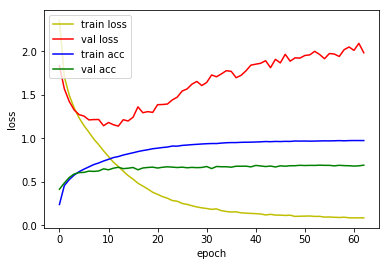

4815/4815 [==============================] - 2s 507us/sample - loss: 1.2567 - acc: 0.6204
Loss: 1.2567360265480272 Accuracy: 0.62035304

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5146 - acc: 0.1818
Epoch 00001: val_loss improved from inf to 2.14588, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_5_conv_checkpoint/001-2.1459.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 2.5145 - acc: 0.1818 - val_loss: 2.1459 - val_acc: 0.3051
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7738 - acc: 0.4393
Epoch 00002: val_loss improved from 2.14588 to 1.53595, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_5_conv_checkpoint/002-1.5359.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.7738 - acc: 0.4393 - val_loss: 1.5359 - val_acc: 0.5036
Epoch 3/500
36800/36805 [=================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3969 - acc: 0.8737
Epoch 00025: val_loss did not improve from 0.95043
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3969 - acc: 0.8737 - val_loss: 1.0325 - val_acc: 0.7209
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3586 - acc: 0.8875
Epoch 00026: val_loss did not improve from 0.95043
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3586 - acc: 0.8875 - val_loss: 1.0521 - val_acc: 0.7275
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3387 - acc: 0.8916
Epoch 00027: val_loss did not improve from 0.95043
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3387 - acc: 0.8916 - val_loss: 1.1355 - val_acc: 0.7114
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3241 - acc: 0.8961
Epoch 00028: val_loss did not improve from 0.95043
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1263 - acc: 0.9593
Epoch 00055: val_loss did not improve from 0.95043
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1263 - acc: 0.9594 - val_loss: 1.3336 - val_acc: 0.7407
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1198 - acc: 0.9637
Epoch 00056: val_loss did not improve from 0.95043
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1198 - acc: 0.9636 - val_loss: 1.5184 - val_acc: 0.7328
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1253 - acc: 0.9608
Epoch 00057: val_loss did not improve from 0.95043
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1252 - acc: 0.9608 - val_loss: 1.3586 - val_acc: 0.7421
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1177 - acc: 0.9633
Epoch 00058: val_loss did not improve from 0.95043
36805/36805 [===========

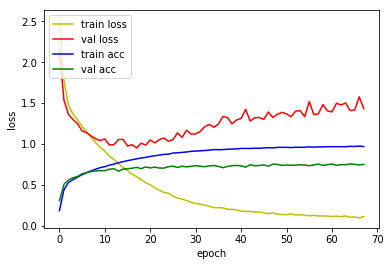

4815/4815 [==============================] - 3s 533us/sample - loss: 1.0726 - acc: 0.6845
Loss: 1.072585623992195 Accuracy: 0.6845275

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6288 - acc: 0.1287
Epoch 00001: val_loss improved from inf to 2.38203, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_6_conv_checkpoint/001-2.3820.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 2.6288 - acc: 0.1287 - val_loss: 2.3820 - val_acc: 0.2285
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9816 - acc: 0.3593
Epoch 00002: val_loss improved from 2.38203 to 1.51741, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_6_conv_checkpoint/002-1.5174.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.9817 - acc: 0.3593 - val_loss: 1.5174 - val_acc: 0.5176
Epoch 3/500
36800/36805 [===================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1775 - acc: 0.9428
Epoch 00050: val_loss did not improve from 0.42948
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1775 - acc: 0.9428 - val_loss: 0.4782 - val_acc: 0.8854
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1751 - acc: 0.9434
Epoch 00051: val_loss did not improve from 0.42948
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1751 - acc: 0.9434 - val_loss: 0.4563 - val_acc: 0.8894
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1671 - acc: 0.9451
Epoch 00052: val_loss did not improve from 0.42948
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1671 - acc: 0.9451 - val_loss: 0.4758 - val_acc: 0.8824
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1617 - acc: 0.9475
Epoch 00053: val_loss did not improve from 0.42948
36805/36805 [========================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0956 - acc: 0.9698
Epoch 00080: val_loss did not improve from 0.42948
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0955 - acc: 0.9698 - val_loss: 0.5450 - val_acc: 0.8889
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0896 - acc: 0.9703
Epoch 00081: val_loss did not improve from 0.42948
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0896 - acc: 0.9703 - val_loss: 0.5636 - val_acc: 0.8891
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0917 - acc: 0.9707
Epoch 00082: val_loss did not improve from 0.42948
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0917 - acc: 0.9707 - val_loss: 0.5127 - val_acc: 0.8996
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0905 - acc: 0.9702
Epoch 00083: val_loss did not improve from 0.42948
36805/36805 [===========

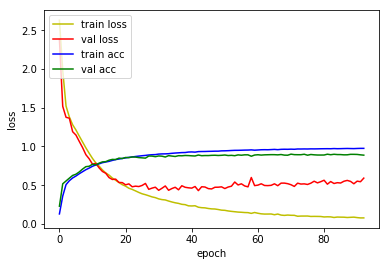

4815/4815 [==============================] - 3s 588us/sample - loss: 0.4972 - acc: 0.8625
Loss: 0.49719522729717186 Accuracy: 0.862513

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5918 - acc: 0.1435
Epoch 00001: val_loss improved from inf to 2.28798, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_7_conv_checkpoint/001-2.2880.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 2.5918 - acc: 0.1435 - val_loss: 2.2880 - val_acc: 0.2867
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0032 - acc: 0.3449
Epoch 00002: val_loss improved from 2.28798 to 1.67965, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_7_conv_checkpoint/002-1.6797.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.0031 - acc: 0.3450 - val_loss: 1.6797 - val_acc: 0.4589
Epoch 3/500
36800/36805 [==================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4042 - acc: 0.8733
Epoch 00024: val_loss improved from 0.40947 to 0.37568, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_7_conv_checkpoint/024-0.3757.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.4041 - acc: 0.8733 - val_loss: 0.3757 - val_acc: 0.8980
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3849 - acc: 0.8789
Epoch 00025: val_loss did not improve from 0.37568
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.3848 - acc: 0.8789 - val_loss: 0.3872 - val_acc: 0.8954
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3678 - acc: 0.8857
Epoch 00026: val_loss improved from 0.37568 to 0.34843, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_7_conv_checkpoint/026-0.3484.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.36

36800/36805 [============================>.] - ETA: 0s - loss: 0.1231 - acc: 0.9590
Epoch 00078: val_loss did not improve from 0.23845
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1231 - acc: 0.9590 - val_loss: 0.2462 - val_acc: 0.9411
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1176 - acc: 0.9614
Epoch 00079: val_loss did not improve from 0.23845
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1176 - acc: 0.9614 - val_loss: 0.2504 - val_acc: 0.9436
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1147 - acc: 0.9621
Epoch 00080: val_loss did not improve from 0.23845
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1147 - acc: 0.9621 - val_loss: 0.2588 - val_acc: 0.9432
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1143 - acc: 0.9615
Epoch 00081: val_loss did not improve from 0.23845
36805/36805 [========================

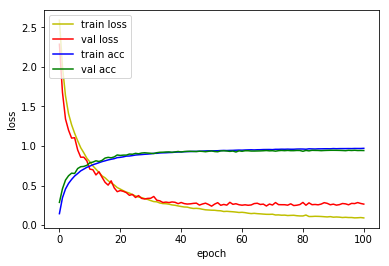

4815/4815 [==============================] - 3s 558us/sample - loss: 0.2752 - acc: 0.9192
Loss: 0.2752435742385167 Accuracy: 0.9192108

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6385 - acc: 0.1360
Epoch 00001: val_loss improved from inf to 2.35072, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_8_conv_checkpoint/001-2.3507.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 2.6386 - acc: 0.1359 - val_loss: 2.3507 - val_acc: 0.2455
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1492 - acc: 0.2954
Epoch 00002: val_loss improved from 2.35072 to 1.79682, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_8_conv_checkpoint/002-1.7968.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.1492 - acc: 0.2953 - val_loss: 1.7968 - val_acc: 0.4163
Epoch 3/500
36800/36805 [==================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3146 - acc: 0.8971
Epoch 00023: val_loss did not improve from 0.26844
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.3147 - acc: 0.8971 - val_loss: 0.2889 - val_acc: 0.9166
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2968 - acc: 0.9018
Epoch 00024: val_loss improved from 0.26844 to 0.26126, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_8_conv_checkpoint/024-0.2613.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2968 - acc: 0.9018 - val_loss: 0.2613 - val_acc: 0.9210
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2952 - acc: 0.9032
Epoch 00025: val_loss improved from 0.26126 to 0.25239, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_8_conv_checkpoint/025-0.2524.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.29

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1627 - acc: 0.9452
Epoch 00050: val_loss did not improve from 0.18576
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1627 - acc: 0.9452 - val_loss: 0.1881 - val_acc: 0.9429
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1544 - acc: 0.9480
Epoch 00051: val_loss did not improve from 0.18576
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1544 - acc: 0.9480 - val_loss: 0.2069 - val_acc: 0.9415
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1559 - acc: 0.9479
Epoch 00052: val_loss did not improve from 0.18576
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1559 - acc: 0.9479 - val_loss: 0.1973 - val_acc: 0.9439
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1498 - acc: 0.9496
Epoch 00053: val_loss did not improve from 0.18576
36805/36805 [===========

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0997 - acc: 0.9664
Epoch 00079: val_loss did not improve from 0.17469
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0998 - acc: 0.9663 - val_loss: 0.1853 - val_acc: 0.9541
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0976 - acc: 0.9655
Epoch 00080: val_loss did not improve from 0.17469
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0976 - acc: 0.9655 - val_loss: 0.1979 - val_acc: 0.9525
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0946 - acc: 0.9679
Epoch 00081: val_loss did not improve from 0.17469
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0946 - acc: 0.9679 - val_loss: 0.2087 - val_acc: 0.9495
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0969 - acc: 0.9672
Epoch 00082: val_loss did not improve from 0.17469
36805/36805 [===========

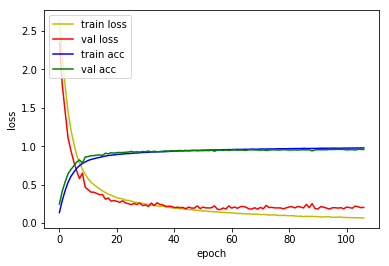

4815/4815 [==============================] - 3s 579us/sample - loss: 0.2247 - acc: 0.9310
Loss: 0.22471109002611966 Accuracy: 0.9310488

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5026 - acc: 0.1884
Epoch 00001: val_loss improved from inf to 2.02844, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_9_conv_checkpoint/001-2.0284.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 2.5025 - acc: 0.1885 - val_loss: 2.0284 - val_acc: 0.3699
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9279 - acc: 0.3946
Epoch 00002: val_loss improved from 2.02844 to 1.60976, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_9_conv_checkpoint/002-1.6098.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.9278 - acc: 0.3946 - val_loss: 1.6098 - val_acc: 0.4801
Epoch 3/500
36800/36805 [=================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2332 - acc: 0.9221
Epoch 00023: val_loss did not improve from 0.23046
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2332 - acc: 0.9222 - val_loss: 0.2728 - val_acc: 0.9087
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2270 - acc: 0.9250
Epoch 00024: val_loss improved from 0.23046 to 0.21894, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_9_conv_checkpoint/024-0.2189.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2269 - acc: 0.9250 - val_loss: 0.2189 - val_acc: 0.9306
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2151 - acc: 0.9287
Epoch 00025: val_loss improved from 0.21894 to 0.21413, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_9_conv_checkpoint/025-0.2141.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.21

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0909 - acc: 0.9694
Epoch 00050: val_loss did not improve from 0.18076
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0910 - acc: 0.9694 - val_loss: 0.1861 - val_acc: 0.9469
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0863 - acc: 0.9708
Epoch 00051: val_loss did not improve from 0.18076
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0863 - acc: 0.9707 - val_loss: 0.1834 - val_acc: 0.9515
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0818 - acc: 0.9711
Epoch 00052: val_loss did not improve from 0.18076
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0818 - acc: 0.9711 - val_loss: 0.1963 - val_acc: 0.9476
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0781 - acc: 0.9729
Epoch 00053: val_loss did not improve from 0.18076
36805/36805 [===========

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.9840
Epoch 00080: val_loss did not improve from 0.18076
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0481 - acc: 0.9840 - val_loss: 0.2493 - val_acc: 0.9478
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9846
Epoch 00081: val_loss did not improve from 0.18076
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0434 - acc: 0.9846 - val_loss: 0.2597 - val_acc: 0.9515
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9849
Epoch 00082: val_loss did not improve from 0.18076
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0434 - acc: 0.9849 - val_loss: 0.2518 - val_acc: 0.9532
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9855
Epoch 00083: val_loss did not improve from 0.18076
36805/36805 [===========

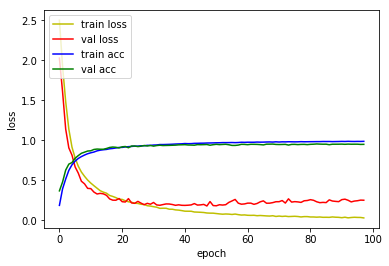

4815/4815 [==============================] - 3s 626us/sample - loss: 0.2923 - acc: 0.9223
Loss: 0.29233125300917423 Accuracy: 0.9223261



In [10]:
base = '1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO'
    
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [ ]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_4_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 32)     

4815/4815 [==============================] - 3s 540us/sample - loss: 0.4972 - acc: 0.8625
Loss: 0.49719522729717186 Accuracy: 0.862513

1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_124 (Conv1D

4815/4815 [==============================] - 3s 613us/sample - loss: 0.2923 - acc: 0.9223
Loss: 0.29233125300917423 Accuracy: 0.9223261


In [ ]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 5333, 32)          3104      
_________________________________________________________________
conv1d_95 (Conv1D)   

4815/4815 [==============================] - 3s 605us/sample - loss: 0.6910 - acc: 0.8685
Loss: 0.6909672454386362 Accuracy: 0.8685358

1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_124 (Conv1D